# Advanced Modeling and Simulation Course

### Instructor: Dr. M. Nedim ALPDEMİR

*This material is prepared as part of the EE592-Advanced Modeling And Simulation course given at Ankara Yıldırım Beyazıt University (AYBÜ).*

## Combined Simulation Example

### Problem Description

* A steel plant has a soaking pit furnace which is being used to heat up steel ingots. 
* The interarrival time of the ingots is exponentially distributed with a mean of 1.5 hours. 
* If a soaking pit is available when an ingot arrives, the ingot is immediately put into the furnace.
* Otherwise it is put into a warming pit where it retains its initial temperature until a soaking pit is available. 
* Initial ingot temperature is uniformly distributed between 40 and 95 degrees celcius.
* Furnace heats up these ingots to a temperature that is uniformly distributed between 425 and 535 degrees
* Furnace temperature is assumed to be constant and 950 degrees.
* The temperature update of the ingots should be done by solving a **differential equation** of the form:

    $\frac{dh}{dt} = (H - h) \times c$
    
    
* where  $H$ is Furnace temperature, $c$ heating time coefficient of the this ingot defined as $(0.07 + x)$, where $x$ is normally distributed with a mean of $0.05$ and a standard deviation of $0.01$

*NOTE: The problem description is adapted from the work titled "Introduction to Combined Discrete-Contnuous Simulation Using SIMSCRIPT II.5" by Abdel-Moaty M Fayek, accessed from the web site at  http://www.caciasl.com/cust_center/ss3docs/contin.pdf*

### Simulation Experiment

* Assume that there are a maximum of nine soaking pits  
* simulate the heating process for 30 days (720 hours). 
* Record both ingot waiting time and furnace utilization statistics.
* Schedule the arrival of the first ingot at time 0.

![steel plant](SteelPlant.png)

In [31]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
import random
from scipy.integrate import ode

def intFunc(t, y, H, c):
    dy = (H-y) * c
    return dy

class Ingot:
    """
    this class defines the ingots to be heated in a soaking pit furnace.
    The temperature update is done by solving a differential equation of the form:
    dh/dt = (H - h) * c; H: Furnace temperature, c: heating time coefficient of the this ingot 
    defined as (0.07 + x), where x is normally distributed with a mean of 0.05 and a standard deviation of 0.01
    """
    def __init__(self, id, crTime):
        self.id = id
        self.initialTemp = random.uniform(40,95)
        self.finalTemp = random.uniform(425,535)
        self.c = random.normalvariate(0.05, 0.01) # heating coefficient with mean: 0.05, std dev : 0.01
        self.H = 950.0 # Furnace Temperature is assumed to be constant and 815 degrees celcius
        self.currentTemp = 0 # will be updated at time steps by the solver
        self.creation_time = crTime
        self.releaseIntTime = 0 # will be set when this ingot leaves the furnace
        self.currentIntTime = 0.0
        self.finalTempReached = False   
        self.solv = ode(intFunc)
        t_0 = 0.0
        self.solv.set_initial_value(self.initialTemp, t_0).set_f_params(self.H, self.c)
        self.solv.set_integrator("dopri5")
    
    def updateTemperature(self, dt):  
        """
        this function integrates differential equation dh/dt = (H - h) * c one step at a time.
        Then checks if the final temperature is reached. The time step must be provided and it must be the same (in synch) 
        with the global simulation time step that is used to advance time in the Atomic DEVS model
        """
        self.currentIntTime += dt
        self.solv.integrate(self.currentIntTime)
        self.currentTemp = self.solv.y
        if self.currentTemp >= self.finalTemp:
            self.finalTempReached = True
            self.releaseIntTime = self.currentIntTime

        return self.finalTempReached


In [32]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
from pypdevs.DEVS import AtomicDEVS
#from Ingot import Ingot
import random

"""
A steel plant has a soaking pit furnace which is being used to heat up steel ingots. The interarrival
time of the ingots is exponentially distributed with a mean of 1.5 hours. If a soaking
pit is available when an ingot arrives, the ingot is immediately put into the furnace.
Otherwise it is put into a warming pit where it retains its initial temperature until a soaking
pit is available. 

Initial ingot temperature is uniformly distributed between 37 and 95 degrees celcius.
Furnace heats up these ingots to a temperature that is uniformly distributed between 425 and 540 degrees

Assuming that there are a maximum of nine soaking pits. Simulate the heating process
for 30 days (720 hours). Record both ingot waiting time and furnace utilization statistics.
Schedule the arrival of the first ingot at time 0.
"""
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

# Define the state of the generator as a structured object
class GeneratorState:
    def __init__(self):
        # Current simulation time (statistics)
        self.current_time = 0.0
        # Remaining time until generation of new event
        self.remaining = 0.0
        self.avg_delta_arival = 0.0
        self.gen_num = 0

class IngotGenerator(AtomicDEVS):
    def __init__(self, gen_param):
        AtomicDEVS.__init__(self, "IngotGenerator")
        # Output port for the event
        self.ingot_arrival = self.addOutPort("out_ingot_event")
        # Define the state
        self.state = GeneratorState()
        # Parameters defining the generator's behaviour. i.e. interarrival rate
        self.gen_param = gen_param
        self.state.remaining = 0
        
    def intTransition(self):
        # Update simulation time
        self.state.current_time += self.timeAdvance()     
        self.state.remaining = random.expovariate(self.gen_param)
        self.state.avg_delta_arival = self.state.current_time / self.state.gen_num
        return self.state

    def timeAdvance(self):
        # Return remaining time
        return self.state.remaining

    def outputFnc(self):
        creation_time_interval = self.state.remaining
        self.state.gen_num += 1
        new_ingot = Ingot(self.state.gen_num, creation_time_interval)
        # Output the new event on the output port
        return {self.ingot_arrival: new_ingot}


In [33]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
import collections

class ResourceType():
    FIFO = "FIFO"
    LIFO = "LIFO"

class ResourceUseStats():
    def __init__(self):
        self.queue_start_time = 0
        self.queue_end_time = 0
        self.server_start_time = 0
        self.server_end_time = 0

class Resource():
    def __init__(self, num_servers, cap_queue = 9999, type = ResourceType.FIFO):
        self.type = type
        self.serverCapacity = num_servers
        self.queueCapacity = cap_queue
        self.servers = dict()
        self.queue = collections.deque()


    def seize(self, item, id, current_time):
        stats = ResourceUseStats()
        if len(self.servers) < self.serverCapacity: 
            stats.server_start_time =  current_time    
            self.servers[id] = (item, stats)
        else:
            stats.queue_start_time =  current_time
            self.queue.append([id, (item, stats)])
    
    def release(self, id, current_time):
        ingot_tuple = self.servers.pop(id)
        ingot_tuple[1].server_end_time = current_time
        
        if (len(self.queue)) > 0:
            if self.type == ResourceType.FIFO:
                scheduledItem = self.queue.popleft()
            elif self.type == ResourceType.LIFO:
                scheduledItem = self.queue.pop()
            
            scheduledItem[1][1].queue_end_time = current_time
            scheduledItem[1][1].server_start_time = current_time
            self.servers[scheduledItem[0]] = scheduledItem[1]
        return ingot_tuple

    def getServers(self):
        return self.servers

    def getCurrentQueueSize(self):
        return len(self.queue)

    def getActiveServersNum(self):
        return len(self.servers)

    def getServerCapacity(self):
        return self.serverCapacity

In [34]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
from pypdevs.DEVS import AtomicDEVS
#import Ingot
#import random
import collections
#from Resource import Resource

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.getLogger().setLevel('DEBUG')

class State():
    def __init__(self):
        self.remaining = float("inf")
        self.current_time = 0.0
        self.out_ingots = []
        self.current_queue_size = 0.0

class Furnace(AtomicDEVS):
    """
    This class implements the furnace with a predefined capacity. 
    The Capacity represents the number of servers (i.e. num of soaking pits)
    """
    def __init__(self, furnace_capacity):
        AtomicDEVS.__init__(self, "Furnace")
        self.soakingPits = Resource(num_servers = furnace_capacity)
        self.in_ingot = self.addInPort("in_ingot")
        self.out_hot_ingot = self.addOutPort("out_heated_ingot")
        self.dt = 0.1
        self.state = State()  
        self.hot_ingot_ids = set()
        self.max_WB_queue_size = 0

    def intTransition(self):
        self.state.out_ingots = []    
        # Update simulation time
        if self.soakingPits.getActiveServersNum != 0:
            self.state.current_time += self.timeAdvance() 
            soakingPits = self.soakingPits.getServers()
            for id, ingot_tuple in soakingPits.items():
                if (not ingot_tuple[0].finalTempReached):
                    if (ingot_tuple[0].updateTemperature(self.dt)):
                        # returned true, so this ingot is hot enough to leave the furnace
                        logging.debug("finished integrating. h = %f5.2 - t = %f5.2"%(ingot_tuple[0].currentTemp, ingot_tuple[0].currentIntTime))
                        self.hot_ingot_ids.add(id)
            
            while (self.hot_ingot_ids):
                id = self.hot_ingot_ids.pop()               
                self.state.out_ingots.append(self.soakingPits.release(id, self.state.current_time))

        self.state.current_queue_size = self.soakingPits.getCurrentQueueSize()
        return self.state

    def extTransition(self, inputs):
        self.state.current_time += self.elapsed
        try:
            if self.in_ingot in inputs:
                # Processing incoming ingots, arrived from ingot generator
                # seize one of the  soaking pits in the furnace. If no empty soaking pit exists
                # then the ingot should be queued in the warming bank
                ingot = inputs[self.in_ingot]
                self.soakingPits.seize(ingot, ingot.id, self.state.current_time)
                logging.debug("incoming ingot - id : %d - t:%f5.2"%(ingot.id,ingot.creation_time))
                self.max_WB_queue_size = max(self.max_WB_queue_size, self.soakingPits.getCurrentQueueSize())

        except:
            logging.error("Exception when handling the incoming ingot with ID: %d "%ingot.id)
            raise 
        return self.state

    def timeAdvance(self):
        # Return remaining time; infinity when furnace is empty (wait for ingots to arrive from the port)
        if self.soakingPits.getActiveServersNum == 0 and self.soakingPits.getCurrentQueueSize == 0:
            self.state.remaining = float('inf')
        else:
            self.state.remaining = self.dt

        return self.state.remaining

    def outputFnc(self):
        # Output the new event on the output port
        return {self.out_hot_ingot: self.state.out_ingots}


In [35]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
from pypdevs.DEVS import AtomicDEVS

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

# Define the state of the collector as a structured object
class TransducerState(object):
    def __init__(self):
        # Contains received events and simulation time
        self.events = []
        self.current_time = 0.0
        # stats for plots
        self.time = []
        self.avg_q_wait = []
        self.avg_h_time = []
class SummaryStatistics(object):
    def __init__(self):
        # for furnace utilization we use ρ = λ / c*µ where, ρ is server utilization, 
        # λ is interarrival rate of items, c is number of identical servers
        # and µ is service rate 
        self.avg_warming_queue_wait_time = 0.0
        self.furnace_utilization = 0
        self.avg_ingot_heat_time = 0 # this is mean service time, i.e. inverse of µ
        self.avg_ingot_creation_interval = 0 # this mean interarrival time, i.e. inverse of λ

class Transducer(AtomicDEVS):
    def __init__(self):
        AtomicDEVS.__init__(self, "Transducer")
        self.state = TransducerState()
        self.sum_stats = SummaryStatistics()
        self.in_event = self.addInPort("in_event")
        self.total_heat_time = 0
        self.total_ingot_creation_interval = 0
        self.total_queue_wait_time = 0
        self.total_num_ingots = 0

    def extTransition(self, inputs):
        # Update simulation time
        self.state.current_time += self.elapsed
        
        # Calculate time in queue
        events = inputs[self.in_event]
        if (len(events)) > 0:
            logging.debug("TRANS: current time = %f5.2"%self.state.current_time)
            for e in events:
                self.total_num_ingots += 1
                ingot_queue_wait_time = e[1].queue_end_time - e[1].queue_start_time
                ingot_heat_time = e[1].server_end_time  - e[1].server_start_time
                self.total_queue_wait_time += ingot_queue_wait_time
                self.total_heat_time += ingot_heat_time
                self.total_ingot_creation_interval += e[0].creation_time
                self.sum_stats.avg_ingot_heat_time = self.total_heat_time  / self.total_num_ingots
                self.sum_stats.avg_warming_queue_wait_time = self.total_queue_wait_time / self.total_num_ingots
                self.sum_stats.avg_ingot_creation_interval = self.total_ingot_creation_interval / self.total_num_ingots
        # add plot data
        self.state.time.append(self.state.current_time)
        self.state.avg_h_time.append(self.sum_stats.avg_ingot_heat_time)
        self.state.avg_q_wait.append(self.sum_stats.avg_warming_queue_wait_time)
        return self.state

    # Don't define anything else, as we only store events.
    # Collector has no behaviour of its own.


In [36]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
from pypdevs.DEVS import CoupledDEVS

class SteelPlant(CoupledDEVS):
    def __init__(self, ingot_arr_rate, furnace_capacity):
        CoupledDEVS.__init__(self, "SteelPlant")
        # Define all atomic submodels 
        self.generator = self.addSubModel(IngotGenerator(ingot_arr_rate))
        self.furnace = self.addSubModel(Furnace(furnace_capacity))
        self.transducer = self.addSubModel(Transducer())
        # connect ports
        self.connectPorts(self.generator.ingot_arrival, self.furnace.in_ingot)
        self.connectPorts(self.furnace.out_hot_ingot, self.transducer.in_event)


In [37]:
"""
@author Dr. M. Nedim ALPDEMİR
"""
from pypdevs.simulator import Simulator
import random
#from SteelPlant import SteelPlant

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.getLogger().setLevel('INFO')
# Configuration:
furnace_capacity = 9
max_sim_time = 720.0 # hours
mean_ingot_arr_interv = 1.5 # hours

random.seed(30)
model = SteelPlant(1 / mean_ingot_arr_interv, furnace_capacity) 
# PythonPDEVS specific setup and configuration
sim = Simulator(model)
sim.setClassicDEVS()
sim.setTerminationTime(max_sim_time)
sim.simulate()

# Gather statistical information for output
max_q_size = model.furnace.max_WB_queue_size  
curr_q_size = model.furnace.state.current_queue_size
avg_gen_arrival_dt = model.generator.state.avg_delta_arival 
gen_ingot_num = model.generator.state.gen_num
processed_ingot_num = model.transducer.total_num_ingots
avg_ingot_wait_time = model.transducer.sum_stats.avg_warming_queue_wait_time
avg_service_time = model.transducer.sum_stats.avg_ingot_heat_time
avg_exp_interarriv_time = model.transducer.sum_stats.avg_ingot_creation_interval
furnace_utilization = avg_service_time / (avg_exp_interarriv_time * furnace_capacity)
logging.info("  --------------------------------------------------------------------")
logging.info("  SUMMARY RESULTS")
logging.info("  --------------------------------------------------------------------")
logging.info("  {:25s} : {:10.3f}".format("total generated ingots", gen_ingot_num))
logging.info("  {:25s} : {:10.3f}".format("total processed ingots", processed_ingot_num))
logging.info("  {:25s} : {:10.3f}".format("avg ingot wait time", avg_ingot_wait_time))
logging.info("  {:25s} : {:10.3f}".format("avg ingot interarv time", avg_exp_interarriv_time))
logging.info("  {:25s} : {:10.3f}".format("avg gen interarv time", avg_gen_arrival_dt))
logging.info("  {:25s} : {:10.3f}".format("avg service time", avg_service_time))
logging.info("  {:25s} : {:10.3f}".format("furnace utilization", furnace_utilization))
logging.info("  {:25s} : {:10.3f}".format("maximum WB queue size", max_q_size))
logging.info("  {:25s} : {:10.3f}".format("current WB queue size", curr_q_size))


INFO:  --------------------------------------------------------------------
INFO:  SUMMARY RESULTS
INFO:  --------------------------------------------------------------------
INFO:  total generated ingots    :    476.000
INFO:  total processed ingots    :    459.000
INFO:  avg ingot wait time       :     10.791
INFO:  avg ingot interarv time   :      1.507
INFO:  avg gen interarv time     :      1.506
INFO:  avg service time          :     13.804
INFO:  furnace utilization       :      1.018
INFO:  maximum WB queue size     :     19.000
INFO:  current WB queue size     :      8.000


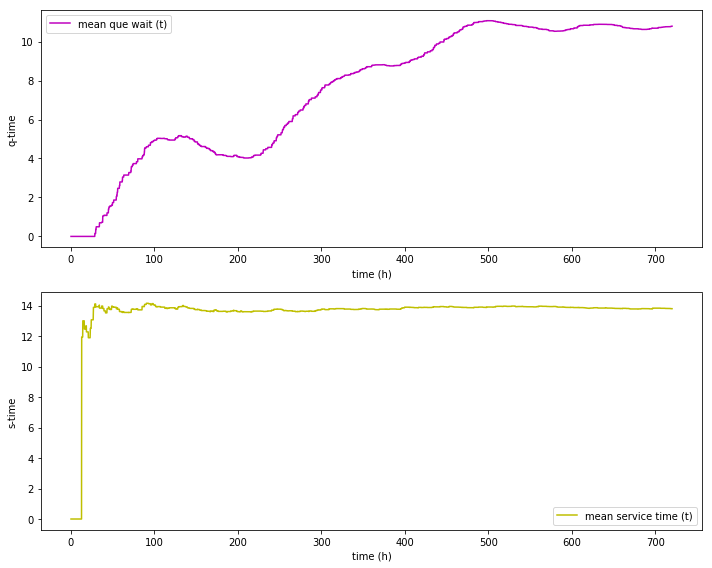

In [41]:
import matplotlib.pyplot as plt
# collect queue system plot data. These are arrays containing directly plottable data
t2 = model.transducer.state.time
mean_w_time = model.transducer.state.avg_q_wait
mean_s_time = model.transducer.state.avg_h_time

plt.figure(1, figsize=(10,8),tight_layout=True)

plt.subplot(2, 1, 1)
plt.plot(t2,mean_w_time,'m-',label='mean que wait (t)')
plt.xlabel('time (h)')
plt.ylabel('q-time')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(t2,mean_s_time,'y-',label='mean service time (t)')
plt.xlabel('time (h)')
plt.ylabel('s-time')
plt.legend(loc='best')

plt.show()